In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


In [2]:
import os
import numpy as np

In [3]:
train, test = chainer.datasets.get_mnist()

In [4]:
index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)

datas = train[index_0and1]

print(len(datas[1]), len(train._datasets[1]))

train._datasets = datas
train._length = len(datas[1])

index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)

datas = test[index_0and1]

print(len(datas[1]), len(test._datasets[1]))

test._datasets = datas
test._length = len(datas[1])

12665 60000
2115 10000


In [5]:
train[:2], test[:2]

([(array([0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        

In [6]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [7]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
#         if self.input_sep_flag:
#             act_var = []
#             for i in range(self.n_separate):
#                 var = F.expand_dims(x.reshape(BATCH_SIZE, self.n_separate, -1)[:, i, :], 1)
#                 act_var.append(self[i](var))
#         else:
#             act_var = []
#             for i in range(self.n_separate):
#                 act_var.append(self[i](x))
#         res = F.concat(act_var, axis=1)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepMLP(Chain):

    def __init__(self, in_size, out_size, n_specific=2):
        super(SepMLP, self).__init__()
        with self.init_scope():
            self.l1 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=in_size, out_size=out_size)
#             self.l2 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
#             self.l3 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
        
#         with self.init_scope():
#             if 0 in separate_layer:
#                 self.l1 = SepLinear(None, n_units//n_sep, n_sep, False)
#             else:
#                 self.l1 = L.Linear(None, n_units)
            
#             if 1 in separate_layer:
#                 if 0 in separate_layer:
#                     flag = True
#                 else:
#                     flag = False
#                 self.l2 = SepLinear(None, n_units//n_sep, n_sep, flag)
#             else:
#                 self.l2 = L.Linear(None, n_units)

#             if 2 in separate_layer:
#                 if 1 in separate_layer:
#                     flag = True
#                 else:
#                     flag = False
#                 self.l3 = SepLinear(None, n_out//n_sep, n_sep, flag)
#             else:
#                 self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
#         print('x', len(x), list(map(lambda x:x.shape, x)))
        h1 = list(map(F.relu, self.l1(x)))
#         print('h1', len(h1), list(map(lambda x:x.shape, h1)))
#         h2 = list(map(F.relu, self.l2(h1)))
#         print('h2', len(h2), list(map(lambda x:x.shape, h2)))
        outs = self.out(h1)
#         print('outs', len(outs), list(map(lambda x:x.shape, outs)))
        out = F.concat(outs, axis=1)
#         print('out', out.shape)
        return out

class MLP(Chain):
    def __init__(self, in_size, out_size, n_specific=2):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, out_size)
            self.l2 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
#         h2 = F.relu(self.l2(h1))
        out = self.out(h1)
        return out

In [8]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'result_new'
    args_unit = int(3**2)
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    out_size = args_unit
#     model = L.Classifier(SepMLP(in_size, out_size))
    model = L.Classifier(MLP(in_size, int(out_size*3)))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepMLP(in_size, out_size))
    print(model.predictor.l1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [9]:
main()

GPU: 0
# unit: 9
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  1.58%
this epoch [#######################################...........] 78.96%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           0.0583012   0.00398013            0.989606       0.999545                  1.55173       
     total [#.................................................]  3.16%
this epoch [############################......................] 57.92%
       200 iter, 1 epoch / 50 epochs
    176.79 iters/sec. Estimated time to finish: 0:00:34.688749.
2           0.00525024  0.00216084            0.998819       0.999545                  2.19318       
     total [##................................................]  4.74%
this epoch [##################................................] 36.87%
      

20          0.000127696  0.00114891            1              0.999545                  14.5174       
     total [####################..............................] 41.06%
this epoch [##########################........................] 52.90%
      2600 iter, 20 epoch / 50 epochs
    184.42 iters/sec. Estimated time to finish: 0:00:20.239264.
21          0.000108857  0.00117632            1              0.999545                  15.216        
     total [#####################.............................] 42.64%
this epoch [###############...................................] 31.86%
      2700 iter, 21 epoch / 50 epochs
    183.84 iters/sec. Estimated time to finish: 0:00:19.759181.
22          9.97887e-05  0.0010801             1              0.999545                  15.8764       
     total [######################............................] 44.22%
this epoch [#####.............................................] 10.82%
      2800 iter, 22 epoch / 50 epochs
    182.66 iters/sec. E

40          1.70845e-05  0.00104435            1              0.999545                  28.2319       
     total [########################################..........] 80.54%
this epoch [#############.....................................] 26.85%
      5100 iter, 40 epoch / 50 epochs
    184.03 iters/sec. Estimated time to finish: 0:00:06.697253.
41          1.53277e-05  0.00101816            1              0.999545                  28.92         
     total [#########################################.........] 82.12%
this epoch [##................................................]  5.80%
      5200 iter, 41 epoch / 50 epochs
    183.63 iters/sec. Estimated time to finish: 0:00:06.167239.
     total [#########################################.........] 83.70%
this epoch [##########################################........] 84.76%
      5300 iter, 41 epoch / 50 epochs
    185.14 iters/sec. Estimated time to finish: 0:00:05.576990.
42          1.4689e-05  0.0010408             1              0

     total [#########.........................................] 18.95%
this epoch [#######################...........................] 47.49%
      1200 iter, 9 epoch / 50 epochs
    120.58 iters/sec. Estimated time to finish: 0:00:42.566113.
10          0.000863126  0.00171328            0.999764       0.999545                  10.1509       
     total [##########........................................] 20.53%
this epoch [#############.....................................] 26.45%
      1300 iter, 10 epoch / 50 epochs
    120.08 iters/sec. Estimated time to finish: 0:00:41.910072.
11          0.000665331  0.00175426            0.999843       0.999545                  11.1624       
     total [###########.......................................] 22.11%
this epoch [##................................................]  5.41%
      1400 iter, 11 epoch / 50 epochs
     119.8 iters/sec. Estimated time to finish: 0:00:41.173007.
     total [###########.......................................]

29          6.39169e-05  0.00137949            1              0.999545                  29.6997       
     total [#############################.....................] 58.43%
this epoch [##########........................................] 21.44%
      3700 iter, 29 epoch / 50 epochs
     121.9 iters/sec. Estimated time to finish: 0:00:21.595771.
30          5.69895e-05  0.00134246            1              0.999545                  30.7468       
     total [##############################....................] 60.01%
this epoch [..................................................]  0.39%
      3800 iter, 30 epoch / 50 epochs
    121.69 iters/sec. Estimated time to finish: 0:00:20.811896.
     total [##############################....................] 61.59%
this epoch [#######################################...........] 79.35%
      3900 iter, 30 epoch / 50 epochs
    122.66 iters/sec. Estimated time to finish: 0:00:19.830904.
31          6.25907e-05  0.00137261            1              

     total [################################################..] 97.91%
this epoch [###############################################...] 95.38%
      6200 iter, 48 epoch / 50 epochs
    122.72 iters/sec. Estimated time to finish: 0:00:01.079692.
49          1.27566e-05  0.00118185            1              0.999545                  50.3828       
     total [#################################################.] 99.49%
this epoch [#####################################.............] 74.34%
      6300 iter, 49 epoch / 50 epochs
    122.63 iters/sec. Estimated time to finish: 0:00:00.265020.
50          1.12737e-05  0.00123402            1              0.999545                  51.3848       


In [10]:
in_size = None
out_size = int(3**2)
vanilla_model = L.Classifier(MLP(in_size, int(out_size*3)))
sep_model = L.Classifier(SepMLP(in_size, out_size))
chainer.serializers.load_npz('./result_new/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_result_new/sep.model', sep_model)

In [11]:
van_mlp = vanilla_model.predictor
print(van_mlp.l1.W.shape)

sep_mlp = sep_model.predictor
for i in range(sep_mlp.l1.n_separate):
    print(sep_mlp.l1[i].W.shape)

(27, 784)
(9, 784)
(9, 784)
(9, 784)


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

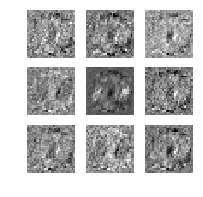

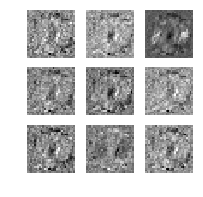

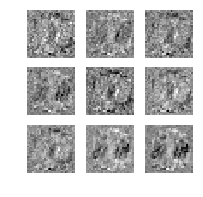

In [13]:
n_row = 3
n_col = 3
for i in range(1, 3+1):
    plt.figure(figsize=(n_row, n_col))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

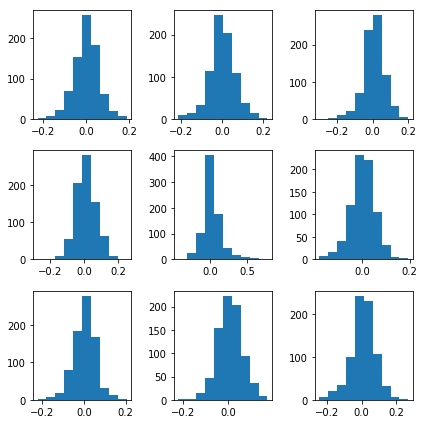

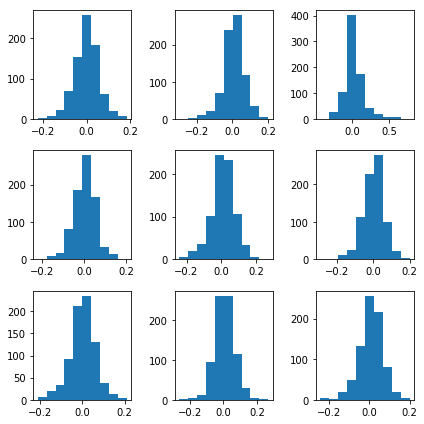

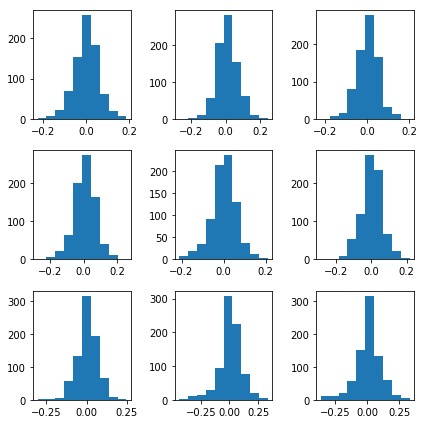

In [14]:
n_row = 3
n_col = 3
for i in range(1, 3+1):
    plt.figure(figsize=(n_row*2, n_col*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
#         plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.hist(van_mlp.l1.W.data[int(i*j)])
#         plt.axis('off')
    plt.tight_layout()
    plt.show()

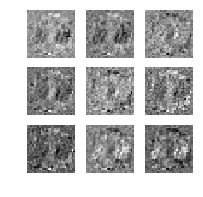

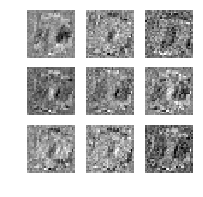

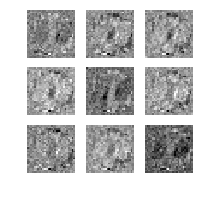

In [15]:
n_row = 3
n_col = 3
for i in range(1, 3+1):
    plt.figure(figsize=(n_row, n_col))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(sep_mlp.l1[i-1].W.data[int(j)].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

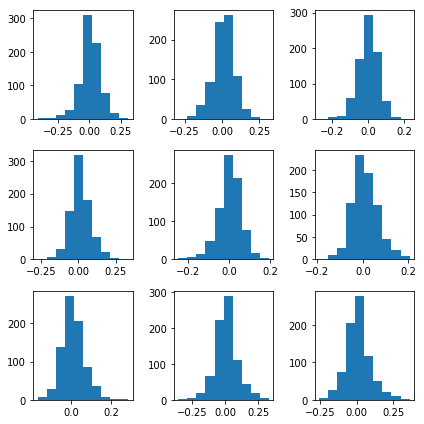

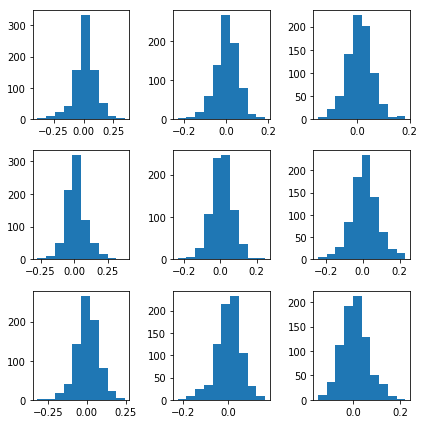

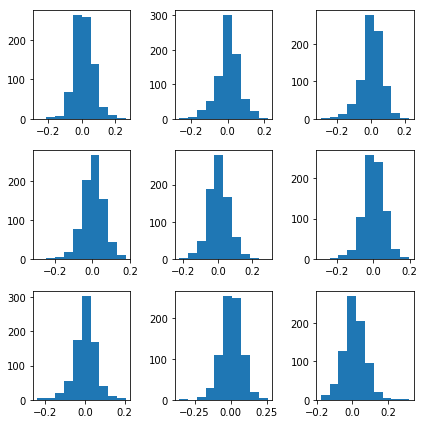

In [16]:
n_row = 3
n_col = 3
for i in range(1, 3+1):
    plt.figure(figsize=(n_row*2, n_col*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
#         plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.hist(sep_mlp.l1[i-1].W.data[int(j)])
#         plt.axis('off')
    plt.tight_layout()
    plt.show()

[[ 0.35520595  0.41472158  0.26057693 -0.35207707  0.33649743  0.09871499
   0.13795026 -0.1798834   0.02035537 -0.12633716  0.39224604  0.07142267
   0.3203851   0.29936463 -0.2432386   0.44937938  0.48086172 -0.29398462
   0.14016409  0.05481388 -0.68136364 -0.09628229 -0.14873788  0.09750571
  -0.0117118  -0.29142463  0.07105327]
 [-0.12418655 -0.11304951 -0.28823215  0.1649468  -0.21738543 -0.3694016
  -0.32046476  0.23204295 -0.48663828  0.33652118 -0.28780928  0.47745502
  -0.07156269 -0.5237449   0.49010605 -0.00685237 -0.12941605  0.20512272
  -0.4337289  -0.40858594  0.29127276  0.31202087  0.48650125  0.48585463
   0.32621416  0.39687568  0.36588532]]


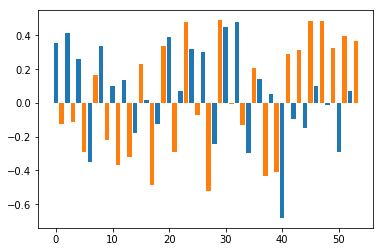

In [17]:
print(van_mlp.out.W.data)
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2, van_mlp.out.W.data[0])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2+1, van_mlp.out.W.data[1])
plt.show()

[[-0.24489853 -0.18794899  0.40517658 -0.64821595  0.27449527 -0.16684002
  -0.323932    0.553334    0.4844217  -0.2783477   0.77198887  0.21072957
  -0.30182335 -0.34655192 -0.4603938   0.45940238  0.5106291  -0.17932758]]


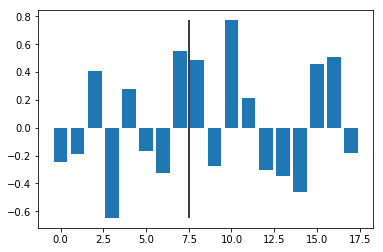

In [18]:
i = 0
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(n_col*n_row - 1.5 , ymin=ymin, ymax=ymax)
plt.show()

[[ 0.2536435   0.25699794 -0.35537377  0.8589217  -0.34231865  0.3147955
   0.2837925  -0.22916302 -0.65419525  0.2821943  -0.3133061  -0.34953964
  -0.5245345   0.613856   -0.3837532  -0.7158491  -0.29600126  0.2790813 ]]


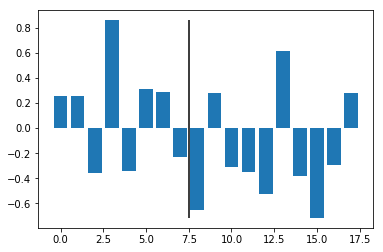

In [19]:
i = 1
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(n_col*n_row - 1.5 , ymin=ymin, ymax=ymax)
plt.show()

In [20]:
sep_mlp.out[1].W

variable W([[ 0.2536435 ,  0.25699794, -0.35537377,  0.8589217 ,
             -0.34231865,  0.3147955 ,  0.2837925 , -0.22916302,
             -0.65419525,  0.2821943 , -0.3133061 , -0.34953964,
             -0.5245345 ,  0.613856  , -0.3837532 , -0.7158491 ,
             -0.29600126,  0.2790813 ]])